In [1]:
!module load cuda11.1/toolkit

import torch
import os
import gpytorch
from botorch.fit import fit_gpytorch_mll
from botorch.models import SingleTaskGP
from botorch.models.utils.gpytorch_modules import (
    get_covar_module_with_dim_scaled_prior,
    get_gaussian_likelihood_with_gamma_prior,
    get_gaussian_likelihood_with_lognormal_prior,
    get_matern_kernel_with_gamma_prior)
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood, ComputationAwareELBO
import math
from matplotlib import pyplot as plt

os.chdir('../src')
from set_seed import set_seed
from models.svgp import SVGPModel
from models.ca_gp import CaGP

from trainers.ca_gp_trainer import LassoDNALogEICaGPSlidingWindowTrainer, OsmbLogEICaGPSlidingWindowTrainer
from trainers.exact_gp_trainer import LassoDNALogEIExactGPTrainer, OsmbLogEIExactGPTrainer
from trainers.svgp_trainer import LassoDNALogEISVGPTrainer, OsmbLogEISVGPTrainer
from models.exact_gp import ExactGPModel


[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.


In [2]:
mock_args = dict(
    epochs=200,
    eulbo_epochs=30,
    device='cuda',
    batch_size=1,
    dropout_prob=0.3,
    save_dir='./',  # Set to your desired path
    data_dir='./',  # Set to your desired path
    optimizer='adam',
    num_repeats=3,
    seed=42,
    learning_rate=1e-2,
    grad_clip=-1,
    ca_gp_actions_learning_rate=1e-2,
    svgp_inducing_point_learning_rate=1e-2,
    max_oracle_calls=101,
    trainer_type='lunar_ei_ca_gp',
    kernel_type='matern_5_2',
    kernel_likelihood_prior='none',
    use_ard_kernel=False,
    ca_gp_init_mode='random',
    norm_data=True,
    turn_off_wandb=True,
    use_analytic_acq_func=True,
    early_stopping_threshold=20,
    num_initial_points=100,
    update_train_size=100,
    num_inducing_points=100,
    proj_dim_ratio=0.5,
    static_proj_dim=100,
    debug=True,
    enable_raasp=True,
    path_to_selfies_vae_files='../src/tasks/utils/selfies_vae/'
)

dataset = 'osmb'

dataset_trainer_mapping = {'osmb': {'svgp': OsmbLogEISVGPTrainer, 
                                    'exact': OsmbLogEIExactGPTrainer, 
                                    'cagp': OsmbLogEICaGPSlidingWindowTrainer},
                           'lasso': {'svgp': LassoDNALogEISVGPTrainer,
                                     'exact': LassoDNALogEIExactGPTrainer,
                                     'cagp': LassoDNALogEICaGPSlidingWindowTrainer}}

In [3]:
# for repeatability
set_seed(mock_args['seed'])

# need this precision for gp fitting
torch.set_default_dtype(torch.float64)
# set default device for cagp
torch.set_default_device(torch.device(mock_args['device']))

In [4]:
def gen_1d_synthetic_data():
    train_x = torch.linspace(0, 1, 100)
    # True function is sin(2*pi*x) with Gaussian noise
    train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)
    return train_x, train_y

## Exact GP - BoTorch LBFGS

In [5]:
exact_gp_trainer = dataset_trainer_mapping[dataset]['exact'](
        optimizer_type=torch.optim.Adam,
        criterion=None,
        tracker=None,
        **mock_args)

In [6]:
train_x_exact, train_y_exact = gen_1d_synthetic_data()
print(f'initial y max: {train_y_exact.max().item()}')
model_train_y_exact = train_y_exact

# Init exact gp model
if exact_gp_trainer.use_ard_kernel:
    ard_num_dims = train_x_exact.shape[-1]
else:
    ard_num_dims = None

if exact_gp_trainer.kernel_likelihood_prior == 'gamma':
    covar_module = get_matern_kernel_with_gamma_prior(
        ard_num_dims=ard_num_dims)
    likelihood = get_gaussian_likelihood_with_gamma_prior()
elif exact_gp_trainer.kernel_likelihood_prior == 'lognormal':
    covar_module = get_covar_module_with_dim_scaled_prior(
        ard_num_dims=ard_num_dims, use_rbf_kernel=False)
    likelihood = get_gaussian_likelihood_with_lognormal_prior()
else:
    if exact_gp_trainer.kernel_type == 'rbf':
        base_kernel = gpytorch.kernels.RBFKernel()
    elif exact_gp_trainer.kernel_type == 'matern_3_2':
        base_kernel = gpytorch.kernels.MaternKernel(1.5)
    else:
        base_kernel = gpytorch.kernels.MaternKernel(2.5)

    covar_module = gpytorch.kernels.ScaleKernel(base_kernel)
    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(
        exact_gp_trainer.device)

exact_gp_trainer.model = SingleTaskGP(
    train_x_exact.view(100, 1),
    model_train_y_exact.view(100, 1),
    covar_module=covar_module,
    likelihood=likelihood,
    outcome_transform=None
).to(exact_gp_trainer.device)

exact_gp_mll = ExactMarginalLogLikelihood(exact_gp_trainer.model.likelihood,
                                            exact_gp_trainer.model)

# fit model to data
mll = fit_gpytorch_mll(exact_gp_mll)
exact_gp_trainer.model.eval()

# get train rmse
train_rmse = exact_gp_trainer.eval(train_x_exact, model_train_y_exact.squeeze())
train_nll = exact_gp_trainer.compute_nll(train_x_exact, model_train_y_exact.squeeze(), exact_gp_mll)
print(f'train_rmse: {train_rmse:.3f}, train_nll: {train_nll:.3f}')
if exact_gp_trainer.kernel_likelihood_prior == 'lognormal':
    outputscale = torch.tensor([1])
    raw_lengthscale = exact_gp_trainer.model.covar_module.raw_lengthscale
    constraint = exact_gp_trainer.model.covar_module.raw_lengthscale_constraint
    lengthscale = constraint.transform(raw_lengthscale)
else:
    raw_outputscale = exact_gp_trainer.model.covar_module.raw_outputscale
    constraint = exact_gp_trainer.model.covar_module.raw_outputscale_constraint
    outputscale = constraint.transform(raw_outputscale)

    raw_lengthscale = exact_gp_trainer.model.covar_module.base_kernel.raw_lengthscale
    constraint = exact_gp_trainer.model.covar_module.base_kernel.raw_lengthscale_constraint
    lengthscale = constraint.transform(raw_lengthscale)

print(f'outputscale: {outputscale.item():.3f}, lengthscale: {torch.mean(lengthscale).item() if mock_args["use_ard_kernel"] else lengthscale.item():.3f}, noise: {exact_gp_trainer.model.likelihood.noise.item():.3f}')

initial y max: 1.5553625965644398


/burg/stats/users/zc2666/project-venvs/cabo-env/lib/python3.11/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


train_rmse: 0.187, train_nll: -0.229
outputscale: 0.710, lengthscale: 0.342, noise: 0.038


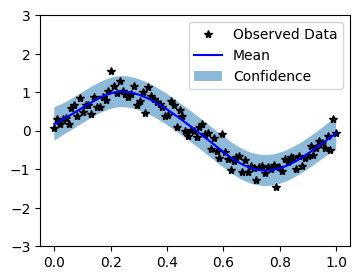

In [7]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = exact_gp_trainer.model.likelihood(exact_gp_trainer.model(test_x))

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x_exact.cpu().numpy(), train_y_exact.cpu().numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.cpu().numpy(), observed_pred.mean.cpu().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])



## Exact GP - torch LBFGS w/ strong wolfe line search

In [8]:
# for repeatability
set_seed(mock_args['seed'])

exact_gp_trainer = dataset_trainer_mapping[dataset]['exact'](
        optimizer_type=torch.optim.Adam,
        criterion=None,
        tracker=None,
        **mock_args)

initial y max: 1.5553625965644398


epoch: 0 training loss: -0.896 patience: 0 outputscale: 0.710 lengthscale: 0.342 noise: 0.038
likelihood.noise_covar.raw_noise norm: 0.000001
mean_module.raw_constant norm: 0.000000
covar_module.raw_outputscale norm: 0.000000
covar_module.base_kernel.raw_lengthscale norm: 0.000000
epoch: 1 training loss: 0.062 patience: 1 outputscale: 0.710 lengthscale: 0.342 noise: 0.038
likelihood.noise_covar.raw_noise norm: 0.000001
mean_module.raw_constant norm: 0.000000
covar_module.raw_outputscale norm: 0.000000
covar_module.base_kernel.raw_lengthscale norm: 0.000000
epoch: 2 training loss: 0.062 patience: 2 outputscale: 0.710 lengthscale: 0.342 noise: 0.038
likelihood.noise_covar.raw_noise norm: 0.000001
mean_module.raw_constant norm: 0.000000
covar_module.raw_outputscale norm: 0.000000
covar_module.base_kernel.raw_lengthscale norm: 0.000000
epoch: 3 training loss: 0.062 patience: 3 outputscale: 0.710 lengthscale: 0.342 noise: 0.038
likelihood.noise_covar.raw_noise norm: 0.000001
mean_module.raw

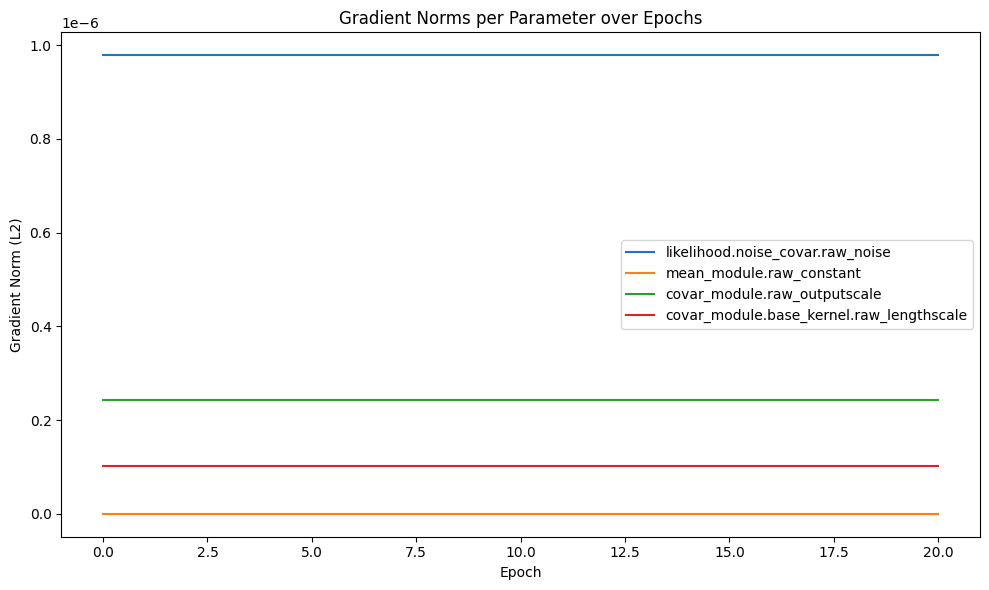

In [9]:
# simulate first round of training
train_x_exact, train_y_exact = gen_1d_synthetic_data()
print(f'initial y max: {train_y_exact.max().item()}')
model_train_y_exact = train_y_exact

# Init exact gp model
if exact_gp_trainer.use_ard_kernel:
    ard_num_dims = train_x_exact.shape[-1]
else:
    ard_num_dims = None

if exact_gp_trainer.kernel_likelihood_prior == 'gamma':
    covar_module = get_matern_kernel_with_gamma_prior(
        ard_num_dims=ard_num_dims)
    likelihood = get_gaussian_likelihood_with_gamma_prior()
elif exact_gp_trainer.kernel_likelihood_prior == 'lognormal':
    covar_module = get_covar_module_with_dim_scaled_prior(
        ard_num_dims=ard_num_dims, use_rbf_kernel=False)
    likelihood = get_gaussian_likelihood_with_lognormal_prior()
else:
    if exact_gp_trainer.kernel_type == 'rbf':
        base_kernel = gpytorch.kernels.RBFKernel()
    elif exact_gp_trainer.kernel_type == 'matern_3_2':
        base_kernel = gpytorch.kernels.MaternKernel(1.5)
    else:
        base_kernel = gpytorch.kernels.MaternKernel(2.5)

    covar_module = gpytorch.kernels.ScaleKernel(base_kernel)
    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(
        exact_gp_trainer.device)


exact_gp_trainer.model = ExactGPModel(
    train_x_exact,
    model_train_y_exact.squeeze(),
    covar_module=covar_module,
    likelihood=likelihood,
).to(exact_gp_trainer.device)
exact_gp_mll = ExactMarginalLogLikelihood(exact_gp_trainer.model.likelihood,
                                            exact_gp_trainer.model)

# fit model to data
exact_gp_trainer.optimizer = torch.optim.LBFGS(exact_gp_trainer.model.parameters(),lr=1, line_search_fn='strong_wolfe')

train_loader = exact_gp_trainer.generate_dataloaders(train_x=train_x_exact,
                                            train_y=model_train_y_exact.squeeze())

final_loss, epochs_trained = exact_gp_trainer.train_model(train_loader, exact_gp_mll)
exact_gp_trainer.model.eval()

# get train rmse
train_rmse = exact_gp_trainer.eval(train_x_exact, model_train_y_exact.squeeze())
train_nll = exact_gp_trainer.compute_nll(train_x_exact, model_train_y_exact.squeeze(), exact_gp_mll)
print(f'train_rmse: {train_rmse:.3f}, train_nll: {train_nll:.3f}')
if exact_gp_trainer.kernel_likelihood_prior == 'lognormal':
    outputscale = torch.tensor([1])
    raw_lengthscale = exact_gp_trainer.model.covar_module.raw_lengthscale
    constraint = exact_gp_trainer.model.covar_module.raw_lengthscale_constraint
    lengthscale = constraint.transform(raw_lengthscale)
else:
    raw_outputscale = exact_gp_trainer.model.covar_module.raw_outputscale
    constraint = exact_gp_trainer.model.covar_module.raw_outputscale_constraint
    outputscale = constraint.transform(raw_outputscale)

    raw_lengthscale = exact_gp_trainer.model.covar_module.base_kernel.raw_lengthscale
    constraint = exact_gp_trainer.model.covar_module.base_kernel.raw_lengthscale_constraint
    lengthscale = constraint.transform(raw_lengthscale)

print(f'outputscale: {outputscale.item():.3f}, lengthscale: {torch.mean(lengthscale).item() if mock_args["use_ard_kernel"] else lengthscale.item():.3f}, noise: {exact_gp_trainer.model.likelihood.noise.item():.3f}')

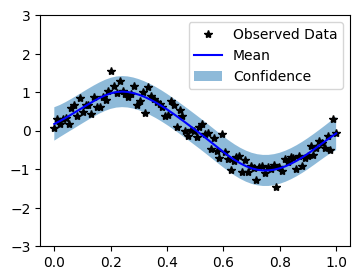

In [10]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = exact_gp_trainer.model.likelihood(exact_gp_trainer.model(test_x))

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x_exact.cpu().numpy(), train_y_exact.cpu().numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.cpu().numpy(), observed_pred.mean.cpu().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])



## Exact GP - torch adam

In [11]:
# for repeatability
set_seed(mock_args['seed'])

exact_gp_trainer = dataset_trainer_mapping[dataset]['exact'](
        optimizer_type=torch.optim.Adam,
        criterion=None,
        tracker=None,
        **mock_args)

initial y max: 1.5553625965644398
epoch: 0 training loss: 0.896 patience: 0 outputscale: 0.744 lengthscale: 0.644 noise: 0.644
likelihood.noise_covar.raw_noise norm: 0.292007
mean_module.raw_constant norm: 0.000513
covar_module.raw_outputscale norm: 0.014775
covar_module.base_kernel.raw_lengthscale norm: 0.067698
epoch: 1 training loss: 0.857 patience: 0 outputscale: 0.798 lengthscale: 0.598 noise: 0.598
likelihood.noise_covar.raw_noise norm: 0.303543
mean_module.raw_constant norm: 0.001402
covar_module.raw_outputscale norm: 0.015392
covar_module.base_kernel.raw_lengthscale norm: 0.073645
epoch: 2 training loss: 0.817 patience: 0 outputscale: 0.854 lengthscale: 0.554 noise: 0.554
likelihood.noise_covar.raw_noise norm: 0.315177
mean_module.raw_constant norm: 0.000437
covar_module.raw_outputscale norm: 0.015090
covar_module.base_kernel.raw_lengthscale norm: 0.075397
epoch: 3 training loss: 0.776 patience: 0 outputscale: 0.913 lengthscale: 0.513 noise: 0.513
likelihood.noise_covar.raw_noi

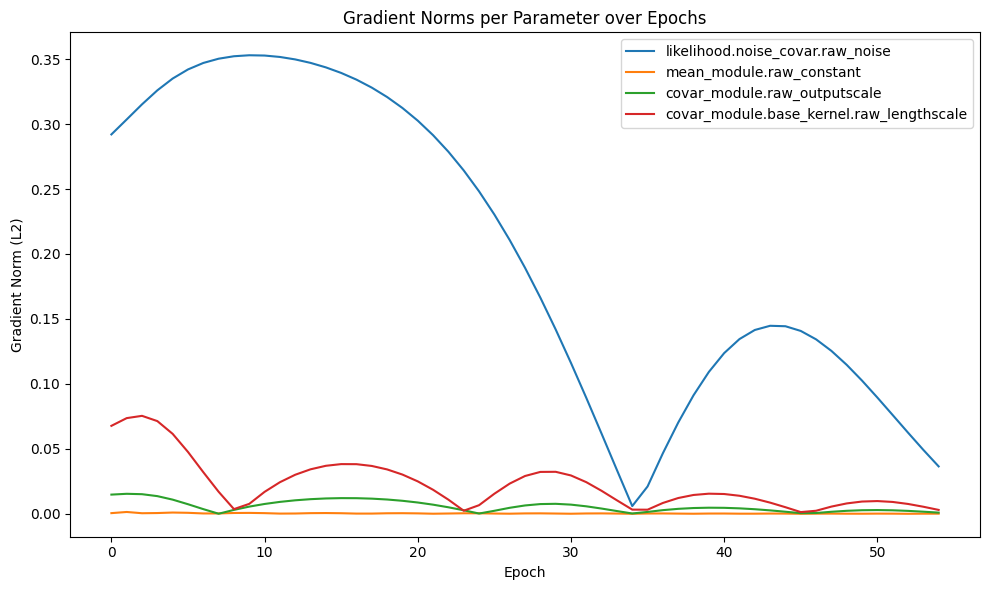

In [12]:
# simulate first round of training
train_x_exact, train_y_exact = gen_1d_synthetic_data()
print(f'initial y max: {train_y_exact.max().item()}')
model_train_y_exact = train_y_exact

# Init exact gp model
if exact_gp_trainer.use_ard_kernel:
    ard_num_dims = train_x_exact.shape[-1]
else:
    ard_num_dims = None

if exact_gp_trainer.kernel_likelihood_prior == 'gamma':
    covar_module = get_matern_kernel_with_gamma_prior(
        ard_num_dims=ard_num_dims)
    likelihood = get_gaussian_likelihood_with_gamma_prior()
elif exact_gp_trainer.kernel_likelihood_prior == 'lognormal':
    covar_module = get_covar_module_with_dim_scaled_prior(
        ard_num_dims=ard_num_dims, use_rbf_kernel=False)
    likelihood = get_gaussian_likelihood_with_lognormal_prior()
else:
    if exact_gp_trainer.kernel_type == 'rbf':
        base_kernel = gpytorch.kernels.RBFKernel()
    elif exact_gp_trainer.kernel_type == 'matern_3_2':
        base_kernel = gpytorch.kernels.MaternKernel(1.5)
    else:
        base_kernel = gpytorch.kernels.MaternKernel(2.5)

    covar_module = gpytorch.kernels.ScaleKernel(base_kernel)
    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(
        exact_gp_trainer.device)


exact_gp_trainer.model = ExactGPModel(
    train_x_exact,
    model_train_y_exact.squeeze(),
    covar_module=covar_module,
    likelihood=likelihood,
).to(exact_gp_trainer.device)
exact_gp_mll = ExactMarginalLogLikelihood(exact_gp_trainer.model.likelihood,
                                            exact_gp_trainer.model)

# fit model to data
train_loader = exact_gp_trainer.generate_dataloaders(train_x=train_x_exact,
                                            train_y=model_train_y_exact.squeeze())

exact_gp_trainer.optimizer = torch.optim.Adam(
    exact_gp_trainer.model.parameters(), lr=1e-1)


final_loss, epochs_trained = exact_gp_trainer.train_model(train_loader, exact_gp_mll)
exact_gp_trainer.model.eval()

# get train rmse
train_rmse = exact_gp_trainer.eval(train_x_exact, model_train_y_exact.squeeze())
train_nll = exact_gp_trainer.compute_nll(train_x_exact, model_train_y_exact.squeeze(), exact_gp_mll)
print(f'train_rmse: {train_rmse:.3f}, train_nll: {train_nll:.3f}')
if exact_gp_trainer.kernel_likelihood_prior == 'lognormal':
    outputscale = torch.tensor([1])
    raw_lengthscale = exact_gp_trainer.model.covar_module.raw_lengthscale
    constraint = exact_gp_trainer.model.covar_module.raw_lengthscale_constraint
    lengthscale = constraint.transform(raw_lengthscale)
else:
    raw_outputscale = exact_gp_trainer.model.covar_module.raw_outputscale
    constraint = exact_gp_trainer.model.covar_module.raw_outputscale_constraint
    outputscale = constraint.transform(raw_outputscale)

    raw_lengthscale = exact_gp_trainer.model.covar_module.base_kernel.raw_lengthscale
    constraint = exact_gp_trainer.model.covar_module.base_kernel.raw_lengthscale_constraint
    lengthscale = constraint.transform(raw_lengthscale)

print(f'outputscale: {outputscale.item():.3f}, lengthscale: {torch.mean(lengthscale).item() if mock_args["use_ard_kernel"] else lengthscale.item():.3f}, noise: {exact_gp_trainer.model.likelihood.noise.item():.3f}')

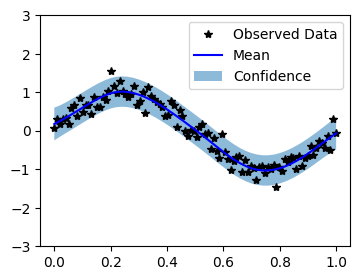

In [13]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = exact_gp_trainer.model.likelihood(exact_gp_trainer.model(test_x))

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x_exact.cpu().numpy(), train_y_exact.cpu().numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.cpu().numpy(), observed_pred.mean.cpu().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])



## CaGP - LBFGS

In [14]:
# for repeatability
set_seed(mock_args['seed'])

cagp_trainer = dataset_trainer_mapping[dataset]['cagp'](
        optimizer_type=torch.optim.Adam,
        tracker=None,
        **mock_args)

epoch: 0 training loss: -0.896 patience: 0 outputscale: 0.710 lengthscale: 0.342 noise: 0.038
non_zero_action_entries norm: 0.000000
likelihood.noise_covar.raw_noise norm: 0.000001
mean_module.raw_constant norm: 0.000000
covar_module.raw_outputscale norm: 0.000000
covar_module.base_kernel.raw_lengthscale norm: 0.000000
epoch: 1 training loss: 0.062 patience: 1 outputscale: 0.710 lengthscale: 0.342 noise: 0.038
non_zero_action_entries norm: 0.000000
likelihood.noise_covar.raw_noise norm: 0.000001
mean_module.raw_constant norm: 0.000000
covar_module.raw_outputscale norm: 0.000000
covar_module.base_kernel.raw_lengthscale norm: 0.000000
epoch: 2 training loss: 0.062 patience: 2 outputscale: 0.710 lengthscale: 0.342 noise: 0.038
non_zero_action_entries norm: 0.000000
likelihood.noise_covar.raw_noise norm: 0.000001
mean_module.raw_constant norm: 0.000000
covar_module.raw_outputscale norm: 0.000000
covar_module.base_kernel.raw_lengthscale norm: 0.000000
epoch: 3 training loss: 0.062 patience:

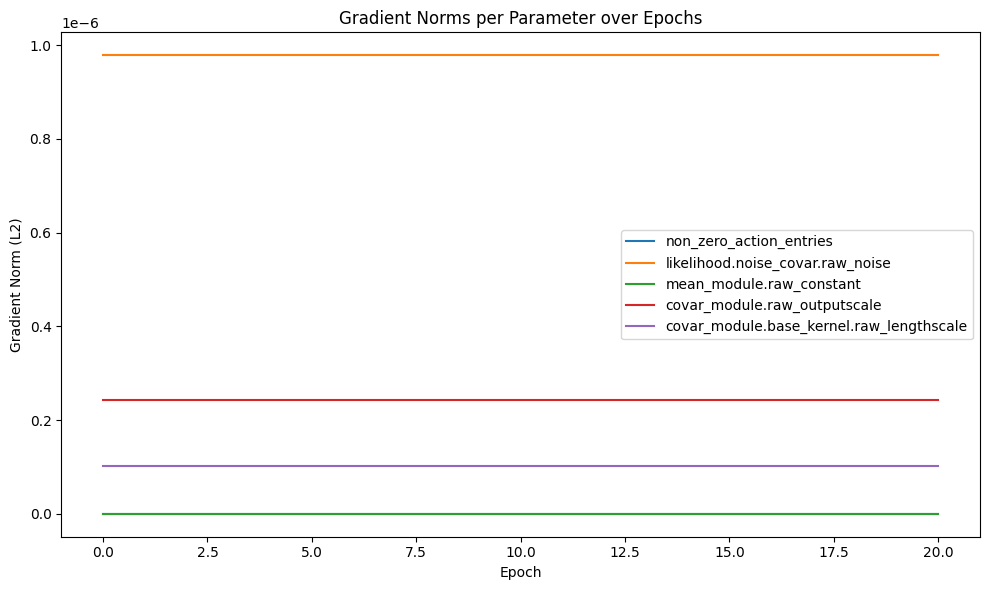

In [15]:
train_x_cagp, train_y_cagp = gen_1d_synthetic_data()

if cagp_trainer.static_proj_dim != -1:
    proj_dim = cagp_trainer.static_proj_dim
else:
    proj_dim = int(cagp_trainer.proj_dim_ratio * train_x_cagp.size(0))

model_train_y_cagp = train_y_cagp

cagp_trainer.model = CaGP(train_inputs=train_x_cagp,
                    train_targets=model_train_y_cagp.squeeze(),
                    projection_dim=100,
                    likelihood=GaussianLikelihood().to(cagp_trainer.device),
                    kernel_type=cagp_trainer.kernel_type,
                    init_mode=cagp_trainer.ca_gp_init_mode,
                    kernel_likelihood_prior=cagp_trainer.kernel_likelihood_prior,
                    use_ard_kernel=cagp_trainer.use_ard_kernel).to(cagp_trainer.device)

update_x_cagp = train_x_cagp
update_y_cagp = model_train_y_cagp.squeeze()

action_params = [
    p for name, p in cagp_trainer.model.named_parameters()
    if 'action' in name
]
others = [
    p for name, p in cagp_trainer.model.named_parameters()
    if 'action' not in name
]


cagp_trainer.optimizer = torch.optim.LBFGS(cagp_trainer.model.parameters(), lr=1, line_search_fn='strong_wolfe')
# cagp_trainer.optimizer = torch.optim.Adam(cagp_trainer.model.parameters(),lr=1e-1)

mll = ComputationAwareELBO(cagp_trainer.model.likelihood, cagp_trainer.model, beta=1)
exact_mll = ExactMarginalLogLikelihood(cagp_trainer.model.likelihood,
                                        cagp_trainer.model)

train_loader = cagp_trainer.generate_dataloaders(train_x=update_x_cagp,
                                            train_y=update_y_cagp)

final_loss, epochs_trained = cagp_trainer.train_model(train_loader, mll)

# calc gradients of actions
total_norm = 0.0
for p in action_params:
    param_norm = p.grad.detach().data.norm(2)
    total_norm += param_norm.item()**2
total_norm = total_norm**0.5
# print(total_norm)
cagp_trainer.model.eval()

train_rmse = cagp_trainer.eval(train_x_cagp, model_train_y_cagp)
train_nll = cagp_trainer.compute_nll(train_x_cagp, model_train_y_cagp.squeeze(),
                                exact_mll)
print(f'train_rmse: {train_rmse:.3f}, train_nll: {train_nll:.3f}')

if cagp_trainer.kernel_likelihood_prior == 'lognormal':
    outputscale = torch.tensor([1])
    raw_lengthscale = cagp_trainer.model.covar_module.raw_lengthscale
    constraint = cagp_trainer.model.covar_module.raw_lengthscale_constraint
    lengthscale = constraint.transform(raw_lengthscale)
else:
    raw_outputscale = cagp_trainer.model.covar_module.raw_outputscale
    constraint = cagp_trainer.model.covar_module.raw_outputscale_constraint
    outputscale = constraint.transform(raw_outputscale)

    raw_lengthscale = cagp_trainer.model.covar_module.base_kernel.raw_lengthscale
    constraint = cagp_trainer.model.covar_module.base_kernel.raw_lengthscale_constraint
    lengthscale = constraint.transform(raw_lengthscale)
print(f'outputscale: {outputscale.item():.3f}, lengthscale: {torch.mean(lengthscale).item() if mock_args["use_ard_kernel"] else lengthscale.item():.3f}, noise: {cagp_trainer.model.likelihood.noise.item():.3f}')

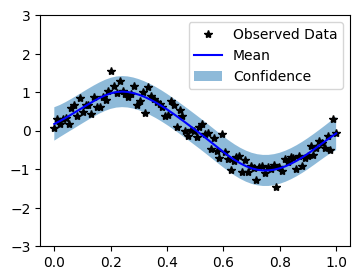

In [16]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = cagp_trainer.model.likelihood(cagp_trainer.model(test_x))

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x_cagp.cpu().numpy(), train_y_cagp.cpu().numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.cpu().numpy(), observed_pred.mean.cpu().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

## CaGP - Adam

In [17]:
# for repeatability
set_seed(mock_args['seed'])

cagp_trainer = dataset_trainer_mapping[dataset]['cagp'](
        optimizer_type=torch.optim.Adam,
        tracker=None,
        **mock_args)

positive kl (want to min): 0.065, positive ll (want to max): -0.831
epoch: 0 training loss: 0.896 patience: 0 outputscale: 0.744 lengthscale: 0.644 noise: 0.644
non_zero_action_entries norm: 0.000000
likelihood.noise_covar.raw_noise norm: 0.292007
mean_module.raw_constant norm: 0.000513
covar_module.raw_outputscale norm: 0.014775
covar_module.base_kernel.raw_lengthscale norm: 0.067698
positive kl (want to min): 0.070, positive ll (want to max): -0.787
epoch: 1 training loss: 0.857 patience: 0 outputscale: 0.798 lengthscale: 0.598 noise: 0.598
non_zero_action_entries norm: 0.000000
likelihood.noise_covar.raw_noise norm: 0.303543
mean_module.raw_constant norm: 0.001402
covar_module.raw_outputscale norm: 0.015392
covar_module.base_kernel.raw_lengthscale norm: 0.073645
positive kl (want to min): 0.074, positive ll (want to max): -0.743
epoch: 2 training loss: 0.817 patience: 0 outputscale: 0.854 lengthscale: 0.554 noise: 0.554
non_zero_action_entries norm: 0.000000
likelihood.noise_covar.r

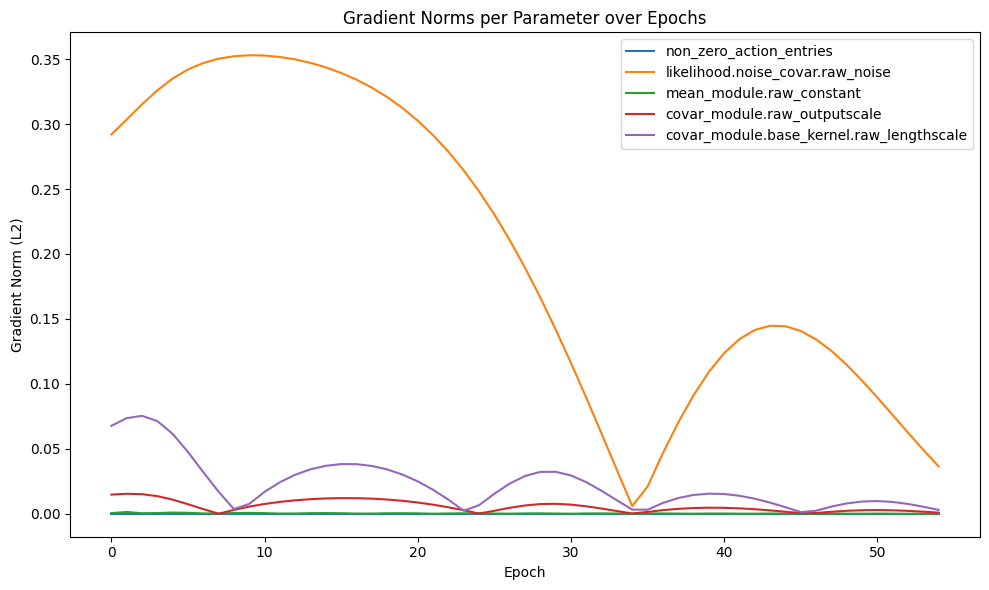

In [18]:
train_x_cagp, train_y_cagp = gen_1d_synthetic_data()

if cagp_trainer.static_proj_dim != -1:
    proj_dim = cagp_trainer.static_proj_dim
else:
    proj_dim = int(cagp_trainer.proj_dim_ratio * train_x_cagp.size(0))

model_train_y_cagp = train_y_cagp

cagp_trainer.model = CaGP(train_inputs=train_x_cagp,
                    train_targets=model_train_y_cagp.squeeze(),
                    projection_dim=100,
                    likelihood=GaussianLikelihood().to(cagp_trainer.device),
                    kernel_type=cagp_trainer.kernel_type,
                    init_mode=cagp_trainer.ca_gp_init_mode,
                    kernel_likelihood_prior=cagp_trainer.kernel_likelihood_prior,
                    use_ard_kernel=cagp_trainer.use_ard_kernel).to(cagp_trainer.device)

update_x_cagp = train_x_cagp
update_y_cagp = model_train_y_cagp.squeeze()

action_params = [
    p for name, p in cagp_trainer.model.named_parameters()
    if 'action' in name
]
others = [
    p for name, p in cagp_trainer.model.named_parameters()
    if 'action' not in name
]

cagp_trainer.optimizer = torch.optim.Adam(cagp_trainer.model.parameters(),lr=1e-1)

mll = ComputationAwareELBO(cagp_trainer.model.likelihood, cagp_trainer.model, beta=1)
exact_mll = ExactMarginalLogLikelihood(cagp_trainer.model.likelihood,
                                        cagp_trainer.model)

train_loader = cagp_trainer.generate_dataloaders(train_x=update_x_cagp,
                                            train_y=update_y_cagp)

final_loss, epochs_trained = cagp_trainer.train_model(train_loader, mll)

# calc gradients of actions
total_norm = 0.0
for p in action_params:
    param_norm = p.grad.detach().data.norm(2)
    total_norm += param_norm.item()**2
total_norm = total_norm**0.5
# print(total_norm)
cagp_trainer.model.eval()

train_rmse = cagp_trainer.eval(train_x_cagp, model_train_y_cagp)
train_nll = cagp_trainer.compute_nll(train_x_cagp, model_train_y_cagp.squeeze(),
                                exact_mll)
print(f'train_rmse: {train_rmse:.3f}, train_nll: {train_nll:.3f}')

if cagp_trainer.kernel_likelihood_prior == 'lognormal':
    outputscale = torch.tensor([1])
    raw_lengthscale = cagp_trainer.model.covar_module.raw_lengthscale
    constraint = cagp_trainer.model.covar_module.raw_lengthscale_constraint
    lengthscale = constraint.transform(raw_lengthscale)
else:
    raw_outputscale = cagp_trainer.model.covar_module.raw_outputscale
    constraint = cagp_trainer.model.covar_module.raw_outputscale_constraint
    outputscale = constraint.transform(raw_outputscale)

    raw_lengthscale = cagp_trainer.model.covar_module.base_kernel.raw_lengthscale
    constraint = cagp_trainer.model.covar_module.base_kernel.raw_lengthscale_constraint
    lengthscale = constraint.transform(raw_lengthscale)
print(f'outputscale: {outputscale.item():.3f}, lengthscale: {torch.mean(lengthscale).item() if mock_args["use_ard_kernel"] else lengthscale.item():.3f}, noise: {cagp_trainer.model.likelihood.noise.item():.3f}')

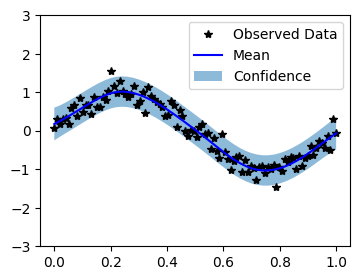

In [19]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = cagp_trainer.model.likelihood(cagp_trainer.model(test_x))

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x_cagp.cpu().numpy(), train_y_cagp.cpu().numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.cpu().numpy(), observed_pred.mean.cpu().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])